In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader

from tqdm import tqdm
import os
import json
import yaml
import time
import numpy as np
import matplotlib.pyplot as plt

#my imports
from models.CNN import CNN
from models.ResNet import ResNet18, create_model
from utils.connectivity import linear_interpolated_model, evaluate_loss
from utils.utils import get_data_loaders
from find_permutation import res_permute

In [20]:
import torch
import numpy as np

def eval_symmetry(weight, symmetry):
    """
    Evaluate the symmetry score S(K) for a given kernel using a specified transformation.
    
    The kernel is first normalized by its Frobenius norm:
         K̂ = K / ||K||_F.
    
    For the specified symmetry, we compute the average Frobenius norm difference between
    the transformed normalized kernel and the original normalized kernel. The score is then:
    
         S(K) = 1 - (delta / (2 * N))
    
    where delta is the sum of differences for all applied transformations and N is the number
    of transformations in that category.
    
    Parameters:
      weight (torch.Tensor): The kernel tensor.
      symmetry (str): A flag indicating the transformation:
          "h"     : horizontal flip (flip left-to-right, i.e. along last dim)
          "v"     : vertical flip (flip top-to-bottom, i.e. along first dim in a 2D kernel)
          "hv"    : both horizontal and vertical flips (applied separately)
          "rot90" : rotations by 90°, 180° and 270° (applied along the last two dims for 2D)
    
    Returns:
      float: The symmetry score.
    """
    # Normalize the kernel
    norm_val = torch.norm(weight, p="fro")
    if norm_val == 0:
        raise ValueError("Kernel has zero Frobenius norm!")
    weight_normalized = weight / norm_val

    if symmetry == "h":
        # For a 2D kernel, horizontal flip (flip left-to-right) flips along last dimension.
        transforms = [lambda x: torch.flip(x, [-1])]
    elif symmetry == "v":
        # For a 2D kernel, vertical flip (flip top-to-bottom) flips along first dimension.
        transforms = [lambda x: torch.flip(x, [-2])]
    elif symmetry == "hv":
        transforms = [lambda x: torch.flip(x, [-1]),
                      lambda x: torch.flip(x, [-2])]
    elif symmetry == "rot90":
        transforms = [lambda x: torch.rot90(x, k=1, dims=(0, 1)),
                      lambda x: torch.rot90(x, k=2, dims=(0, 1)),
                      lambda x: torch.rot90(x, k=3, dims=(0, 1))]
    else:
        raise ValueError("Unknown symmetry flag provided.")

    delta = 0.0
    for transform in transforms:
        transformed = transform(weight_normalized)
        diff = transformed - weight_normalized
        delta += torch.norm(diff, p="fro")
    
    avg_delta = delta / (2 * len(transforms))
    S_K = 1 - avg_delta
    return S_K.item()

# --- Test Script ---

# Define a simple 2D kernel (e.g., a 3x3 kernel)
kernel = torch.tensor([[1.0, 2.0, 3.0],
                       [4.0, 5.0, 6.0],
                       [7.0, 8.0, 9.0]])

print("Test Kernel:")
print(kernel)

symmetry_types = ["h", "v", "hv", "rot90"]

for sym in symmetry_types:
    score = eval_symmetry(kernel, sym)
    print(f"Symmetry score for '{sym}': {score:.4f}")

# Additionally, show the transformed kernels for visual inspection:
print("\nHorizontal flip (sym='h') of the kernel:")
print(torch.flip(kernel, [-1]))

print("\nVertical flip (sym='v') of the kernel:")
print(torch.flip(kernel, [0]))

print("\nBoth flips separately (sym='hv'):")
print("Horizontal flip:")
print(torch.flip(kernel, [-1]))
print("Vertical flip:")
print(torch.flip(kernel, [0]))

print("\nRotations (sym='rot90'):")
print("90° rotation:")
print(torch.rot90(kernel, k=1, dims=(0,1)))
print("180° rotation:")
print(torch.rot90(kernel, k=2, dims=(0,1)))
print("270° rotation:")
print(torch.rot90(kernel, k=3, dims=(0,1)))


Test Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
Symmetry score for 'h': 0.8549
Symmetry score for 'v': 0.5647
Symmetry score for 'hv': 0.7098
Symmetry score for 'rot90': 0.6308

Horizontal flip (sym='h') of the kernel:
tensor([[3., 2., 1.],
        [6., 5., 4.],
        [9., 8., 7.]])

Vertical flip (sym='v') of the kernel:
tensor([[7., 8., 9.],
        [4., 5., 6.],
        [1., 2., 3.]])

Both flips separately (sym='hv'):
Horizontal flip:
tensor([[3., 2., 1.],
        [6., 5., 4.],
        [9., 8., 7.]])
Vertical flip:
tensor([[7., 8., 9.],
        [4., 5., 6.],
        [1., 2., 3.]])

Rotations (sym='rot90'):
90° rotation:
tensor([[3., 6., 9.],
        [2., 5., 8.],
        [1., 4., 7.]])
180° rotation:
tensor([[9., 8., 7.],
        [6., 5., 4.],
        [3., 2., 1.]])
270° rotation:
tensor([[7., 4., 1.],
        [8., 5., 2.],
        [9., 6., 3.]])


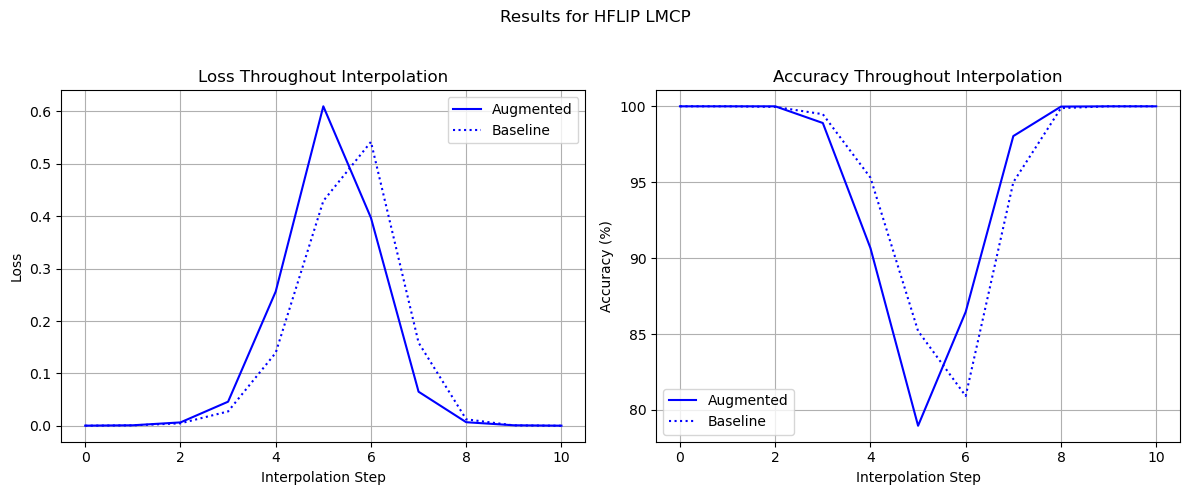

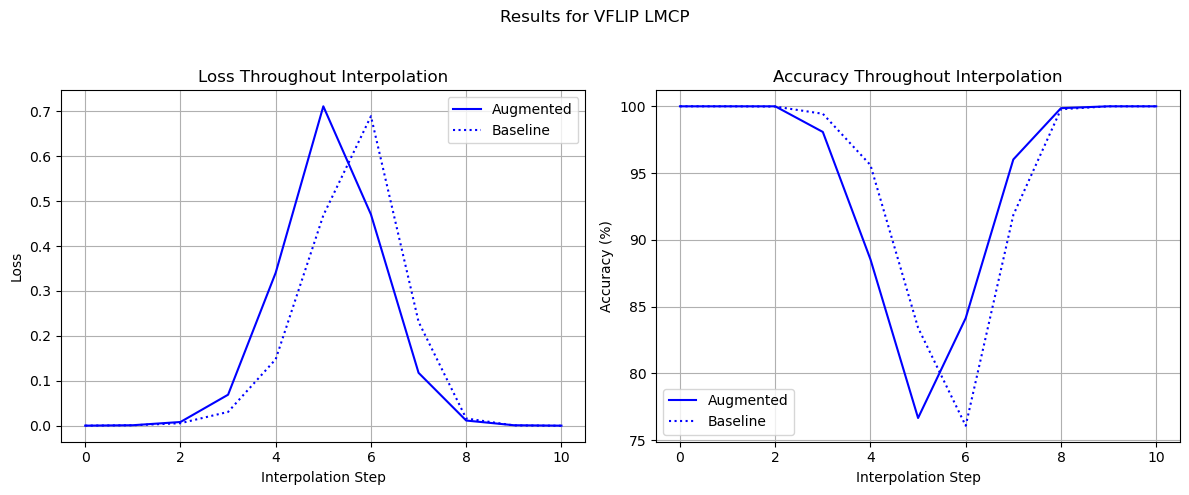

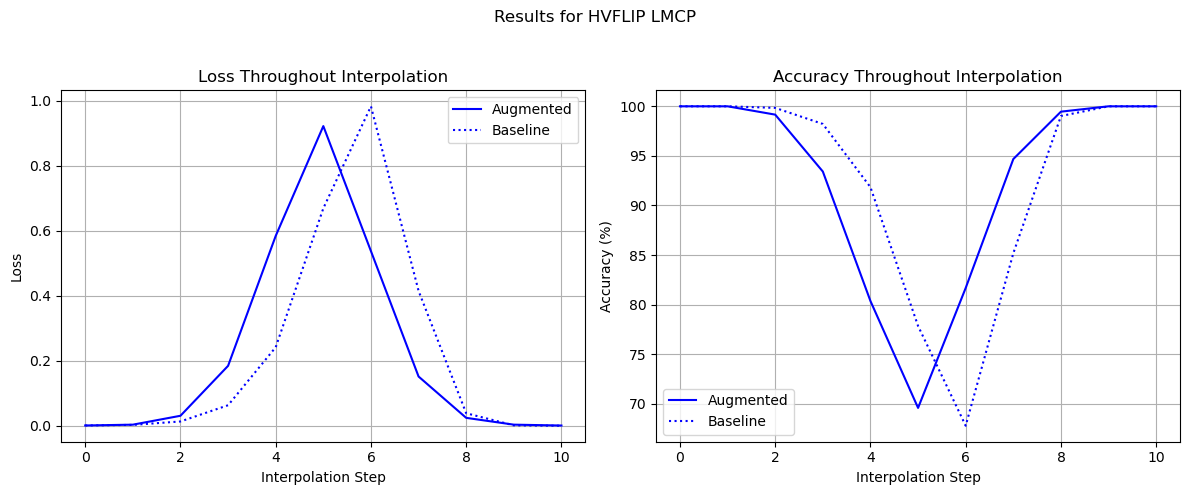

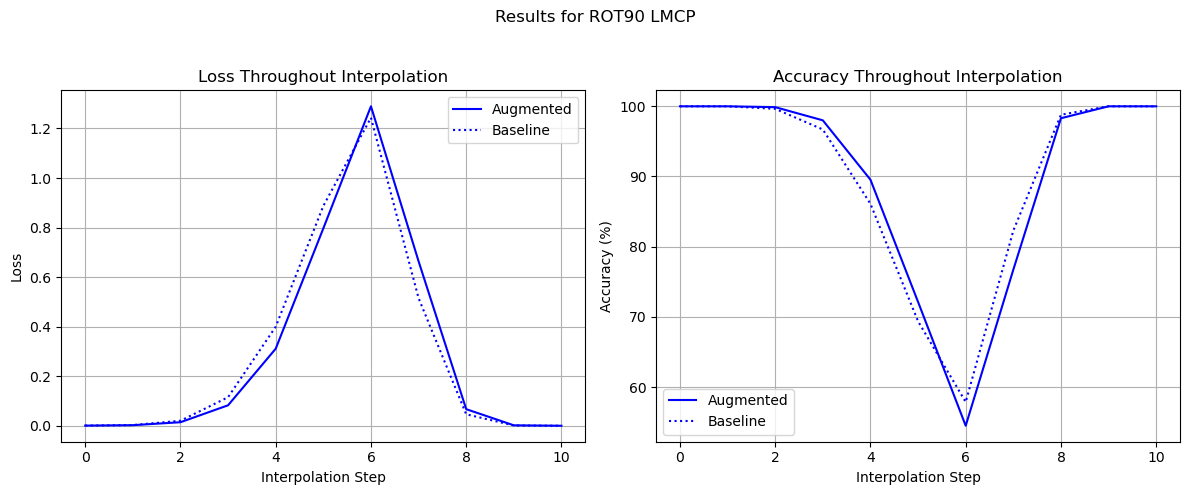

In [18]:
import os
import json
import matplotlib.pyplot as plt

# List of symmetries and interpolation methods
symmetries = ["hflip", "vflip", "hvflip", "rot90"]
methods = ["LMCP"]

# Folder paths
folder_aug = "./logs/connectivity_augmented"  # augmented experiment results
folder_noaug = "./logs/connectivity"             # non-augmented (baseline) results

def load_curve(folder, filename):
    """Load losses and accuracy curves from a JSON file in folder."""
    filepath = os.path.join(folder, filename)
    try:
        with open(filepath, "r") as f:
            data = json.load(f)
        losses = data.get("losses")
        accs = data.get("accs")
        return losses, accs
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None

# Loop over each symmetry and interpolation method (only LMCP in this case)
for sym in symmetries:
    for method in methods:
        method_lower = method.lower()
        
        # Construct file names (with .json extension):
        # Augmented run: e.g. "hflip_aug_to_hflip_symmetry_lmcp.json"
        file_aug = f"{sym}_aug_to_{sym}_symmetry_{method_lower}"
        # Non-augmented (baseline) run: e.g. "vanilla_5_to_hflip_6_lmcp.json"
        file_noaug = f"vanilla_5_to_{sym}_6_{method_lower}"
        
        # Load curves from the two folders.
        losses_aug, accs_aug = load_curve(folder_aug, file_aug)
        losses_noaug, accs_noaug = load_curve(folder_noaug, file_noaug)
        
        if losses_aug is None or losses_noaug is None:
            print(f"Skipping {sym.upper()} {method.upper()} because one file is missing.")
            continue
        
        # Create a new figure for this symmetry and method
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"Results for {sym.upper()} {method.upper()}")
        
        # Define steps based on the length of the curves.
        steps_aug = range(len(losses_aug))
        steps_noaug = range(len(losses_noaug))
        
        # Plot Loss curves: augmented (solid) and baseline (dotted) with the same color.
        ax1.plot(steps_aug, losses_aug, color="blue", linestyle="solid", label="Augmented")
        ax1.plot(steps_noaug, losses_noaug, color="blue", linestyle="dotted", label="Baseline")
        ax1.set_title("Loss Throughout Interpolation")
        ax1.set_xlabel("Interpolation Step")
        ax1.set_ylabel("Loss")
        ax1.legend(loc="best")
        ax1.grid(True)
        
        # Plot Accuracy curves: augmented (solid) and baseline (dotted) with the same color.
        ax2.plot(steps_aug, accs_aug, color="blue", linestyle="solid", label="Augmented")
        ax2.plot(steps_noaug, accs_noaug, color="blue", linestyle="dotted", label="Baseline")
        ax2.set_title("Accuracy Throughout Interpolation")
        ax2.set_xlabel("Interpolation Step")
        ax2.set_ylabel("Accuracy (%)")
        ax2.legend(loc="best")
        ax2.grid(True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


Processing: ./logs/connectivity/hflip_5_to_rot90_6_lmcp
Processing: ./logs/connectivity/hflip_5_to_rot90_6_lmc
Processing: ./logs/connectivity/hflip_5_to_vflip_6_lmcp
Processing: ./logs/connectivity/hflip_5_to_vflip_6_lmc
Processing: ./logs/connectivity/hflip_5_to_hflip_6_lmcp
Processing: ./logs/connectivity/hflip_5_to_hflip_6_lmc
Processing: ./logs/connectivity/hvflip_5_to_hvflip_6_lmcp
Processing: ./logs/connectivity/hvflip_5_to_hvflip_6_lmc
Processing: ./logs/connectivity/hvflip_5_to_rot90_6_lmcp
Processing: ./logs/connectivity/hvflip_5_to_rot90_6_lmc
Processing: ./logs/connectivity/rot90_5_to_rot90_6_lmcp
Processing: ./logs/connectivity/rot90_5_to_rot90_6_lmc
Processing: ./logs/connectivity/vanilla_5_to_hflip_6_lmcp
Processing: ./logs/connectivity/vanilla_5_to_hflip_6_lmc
Processing: ./logs/connectivity/vanilla_5_to_hvflip_6_lmcp
Processing: ./logs/connectivity/vanilla_5_to_hvflip_6_lmc
Processing: ./logs/connectivity/vanilla_5_to_rot90_6_lmcp
Processing: ./logs/connectivity/vanill

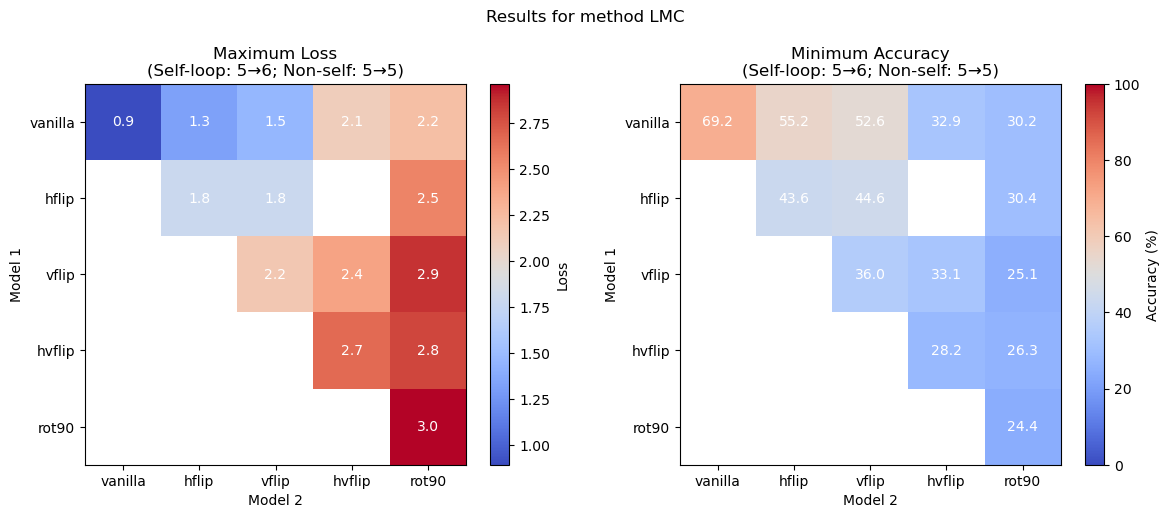

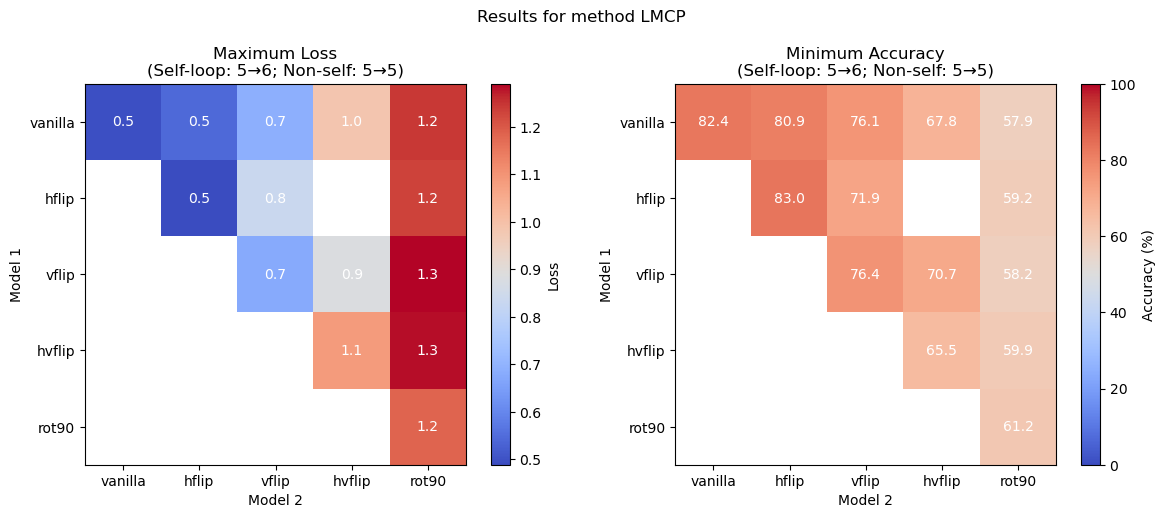

In [32]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Hardcoded list of JSON log file paths to evaluate
files_to_evaluate = [
    "./logs/connectivity/hflip_5_to_rot90_6_lmcp",
    "./logs/connectivity/hflip_5_to_rot90_6_lmc",
    "./logs/connectivity/hflip_5_to_vflip_6_lmcp",
    "./logs/connectivity/hflip_5_to_vflip_6_lmc",
    "./logs/connectivity/hflip_5_to_hflip_6_lmcp",
    "./logs/connectivity/hflip_5_to_hflip_6_lmc",

    "./logs/connectivity/hvflip_5_to_hvflip_6_lmcp",
    "./logs/connectivity/hvflip_5_to_hvflip_6_lmc",
    "./logs/connectivity/hvflip_5_to_rot90_6_lmcp",
    "./logs/connectivity/hvflip_5_to_rot90_6_lmc",

    "./logs/connectivity/rot90_5_to_rot90_6_lmcp",
    "./logs/connectivity/rot90_5_to_rot90_6_lmc",

    "./logs/connectivity/vanilla_5_to_hflip_6_lmcp",
    "./logs/connectivity/vanilla_5_to_hflip_6_lmc",
    "./logs/connectivity/vanilla_5_to_hvflip_6_lmcp",
    "./logs/connectivity/vanilla_5_to_hvflip_6_lmc",
    "./logs/connectivity/vanilla_5_to_rot90_6_lmcp",
    "./logs/connectivity/vanilla_5_to_rot90_6_lmc",
    "./logs/connectivity/vanilla_5_to_vflip_6_lmcp",
    "./logs/connectivity/vanilla_5_to_vflip_6_lmc",
    "./logs/connectivity/vanilla_5_to_vanilla_6_lmcp",
    "./logs/connectivity/vanilla_5_to_vanilla_6_lmc",

    "./logs/connectivity/vflip_5_to_hvflip_6_lmcp",
    "./logs/connectivity/vflip_5_to_hvflip_6_lmc",
    "./logs/connectivity/vflip_5_to_rot90_6_lmcp",
    "./logs/connectivity/vflip_5_to_rot90_6_lmc",
    "./logs/connectivity/vflip_5_to_vflip_6_lmcp",
    "./logs/connectivity/vflip_5_to_vflip_6_lmc",
]


# Define models and the order for the matrix axes
models_list = ["vanilla", "hflip", "vflip", "hvflip", "rot90"]
methods_list = ["lmc", "lmcp"]

# Dictionaries for non-self-loop aggregation:
# For non-self loops: aggregated_loss_results[method][(model1, model2)] holds a list of maximum loss values.
# Similarly, aggregated_acc_results[method][(model1, model2)] holds a list of minimum accuracy values.
aggregated_loss_results = {method: {} for method in methods_list}
aggregated_acc_results = {method: {} for method in methods_list}

# Dictionaries for self-loop (diagonal) values.
# For each method, we store one loss and one accuracy per model using our preferred id combinations.
self_loss = {method: {} for method in methods_list}  # key: model name
self_acc = {method: {} for method in methods_list}    # key: model name

# Process each hardcoded JSON file
for filepath in files_to_evaluate:
    print("Processing:", filepath)
    try:
        with open(filepath, "r") as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"Warning: Could not decode {filepath}, skipping.")
        continue

    # Check that losses and accs exist
    losses = data.get("losses", [])
    accs = data.get("accs", [])
    if not losses or not accs:
        continue

    # Compute the metrics from this run
    max_loss = max(losses)
    min_acc = min(accs)

    # Parse the filename (basename) to extract model names, IDs, and method.
    # Expected format: model1_id_to_model2_id_method.json
    filename = os.path.basename(filepath)
    base = filename.replace(".json", "")
    parts = base.split("_")
    if len(parts) != 6 or parts[2] != "to":
        print(f"Filename {filename} does not match expected format, skipping.")
        continue

    model1 = parts[0]
    id1 = parts[1]
    model2 = parts[3]
    id2 = parts[4]
    method = parts[5].lower()  # Normalize method to lowercase

    if method not in methods_list:
        print(f"Unrecognized method '{method}' in {filename}, skipping.")
        continue

    # Process self-loop cases (where model1 == model2) separately
    if model1 == model2:
        # For self-loops, prefer the file with "5_to_5" IDs; if not, use "5_to_6" as fallback.
        if id1 == "5" and id2 == "5":
            self_loss[method][model1] = max_loss
            self_acc[method][model1] = min_acc
        elif id1 == "5" and id2 == "6":
            if model1 not in self_loss[method]:
                self_loss[method][model1] = max_loss
                self_acc[method][model1] = min_acc
        # Other self-loop id combinations are ignored.
    else:
        # For non-self loops, aggregate values across all id combinations.
        key = (model1, model2)
        aggregated_loss_results[method].setdefault(key, []).append(max_loss)
        aggregated_acc_results[method].setdefault(key, []).append(min_acc)

# For each method, construct matrices for loss and accuracy and plot the heatmaps.
for method in methods_list:
    # Create matrices (5x5) filled initially with NaN values
    loss_matrix = np.full((len(models_list), len(models_list)), np.nan)
    acc_matrix  = np.full((len(models_list), len(models_list)), np.nan)

    for i, m1 in enumerate(models_list):
        for j, m2 in enumerate(models_list):
            if m1 == m2:
                # Self-loop: use the corresponding stored value (or fallback) if present.
                if m1 in self_loss[method]:
                    loss_matrix[i, j] = self_loss[method][m1]
                if m1 in self_acc[method]:
                    acc_matrix[i, j] = self_acc[method][m1]
            else:
                # Non-self loop: average across the aggregated runs.
                key = (m1, m2)
                if key in aggregated_loss_results[method]:
                    avg_loss = np.mean(aggregated_loss_results[method][key])
                    loss_matrix[i, j] = avg_loss
                if key in aggregated_acc_results[method]:
                    avg_acc = np.mean(aggregated_acc_results[method][key])
                    acc_matrix[i, j] = avg_acc

    # Use the "coolwarm" colormap instead of "bwr"
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Results for method {method.upper()}")

    im1 = ax1.imshow(loss_matrix, cmap="coolwarm")
    ax1.set_title("Maximum Loss\n(Self-loop: 5→6; Non-self: 5→5)")
    ax1.set_xticks(range(len(models_list)))
    ax1.set_xticklabels(models_list)
    ax1.set_yticks(range(len(models_list)))
    ax1.set_yticklabels(models_list)
    ax1.set_xlabel("Model 2")
    ax1.set_ylabel("Model 1")
    cbar1 = fig.colorbar(im1, ax=ax1)
    cbar1.set_label("Loss")
    for i in range(len(models_list)):
        for j in range(len(models_list)):
            val = loss_matrix[i, j]
            text = f"{val:.1f}" if not np.isnan(val) else "-"
            ax1.text(j, i, text, ha="center", va="center", color="white", fontsize=10)

    im2 = ax2.imshow(acc_matrix, cmap="coolwarm", vmin=0, vmax=100)
    ax2.set_title("Minimum Accuracy\n(Self-loop: 5→6; Non-self: 5→5)")
    ax2.set_xticks(range(len(models_list)))
    ax2.set_xticklabels(models_list)
    ax2.set_yticks(range(len(models_list)))
    ax2.set_yticklabels(models_list)
    ax2.set_xlabel("Model 2")
    ax2.set_ylabel("Model 1")
    cbar2 = fig.colorbar(im2, ax=ax2)
    cbar2.set_label("Accuracy (%)")
    for i in range(len(models_list)):
        for j in range(len(models_list)):
            val = acc_matrix[i, j]
            text = f"{val:.1f}" if not np.isnan(val) else "-"
            ax2.text(j, i, text, ha="center", va="center", color="white", fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

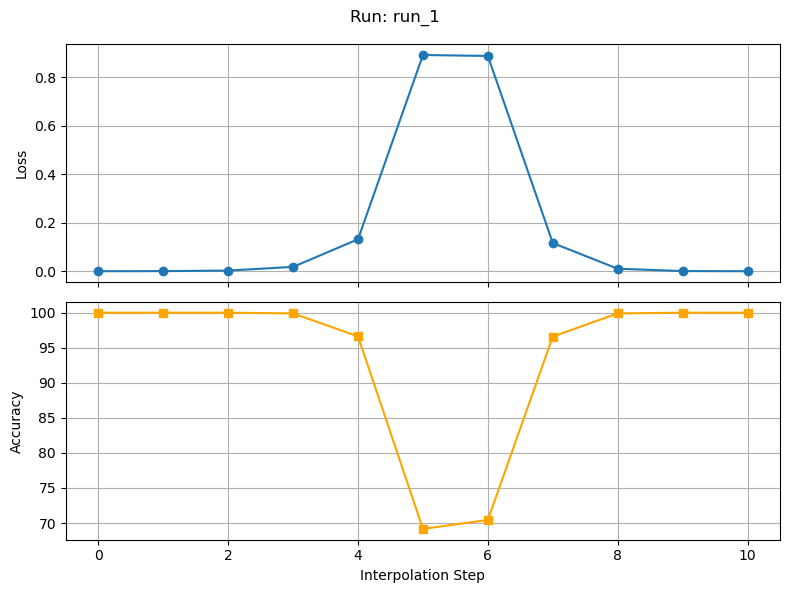

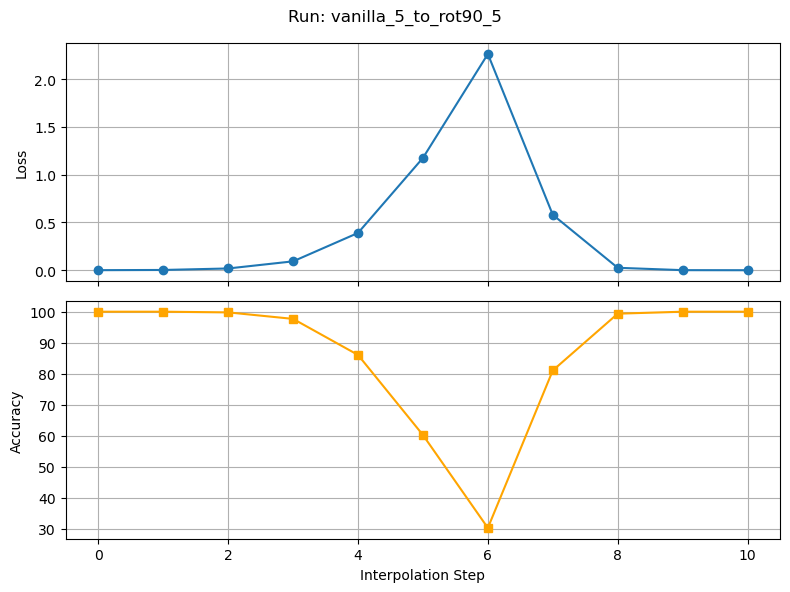

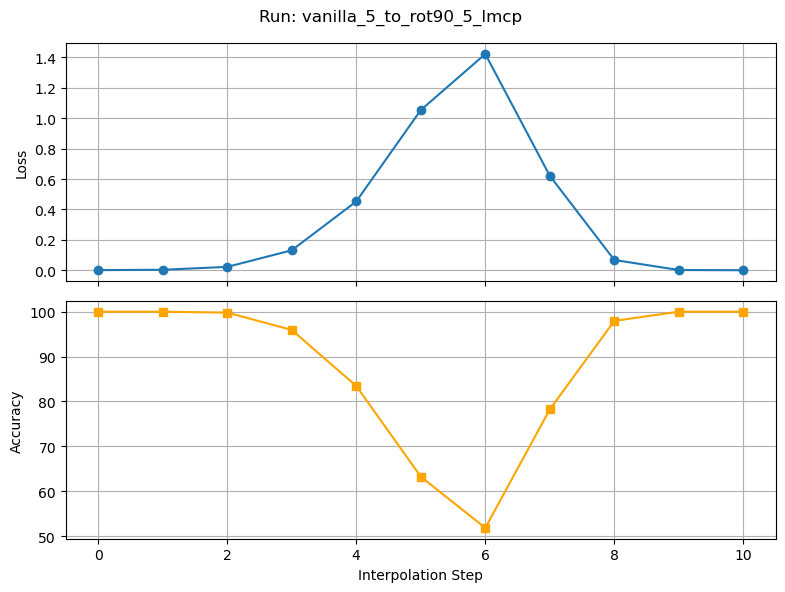

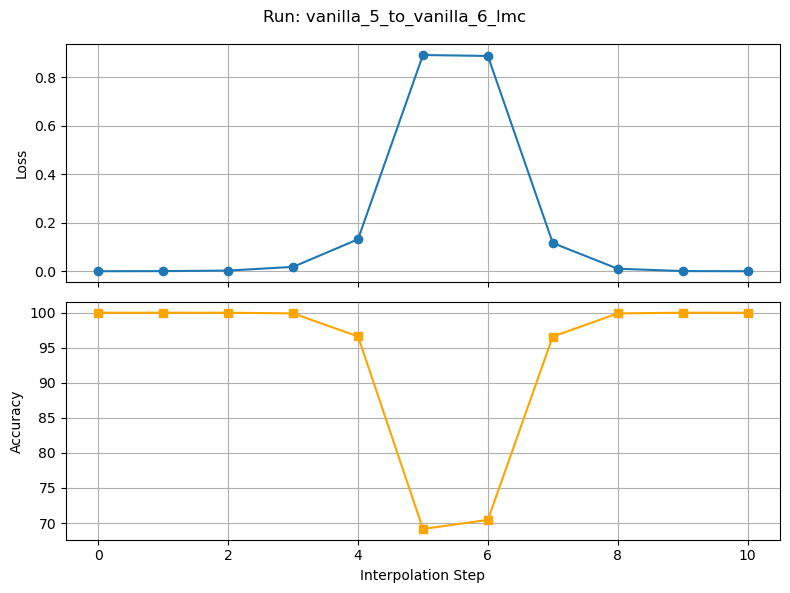

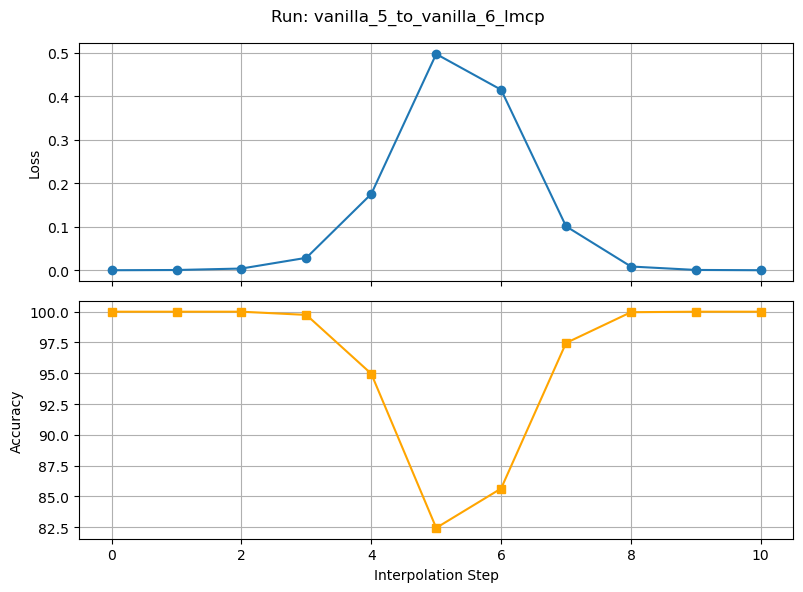

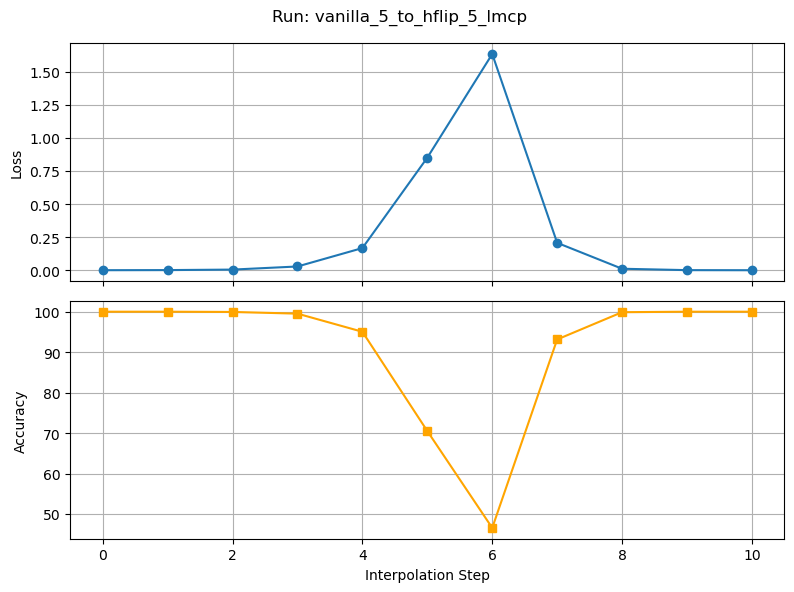

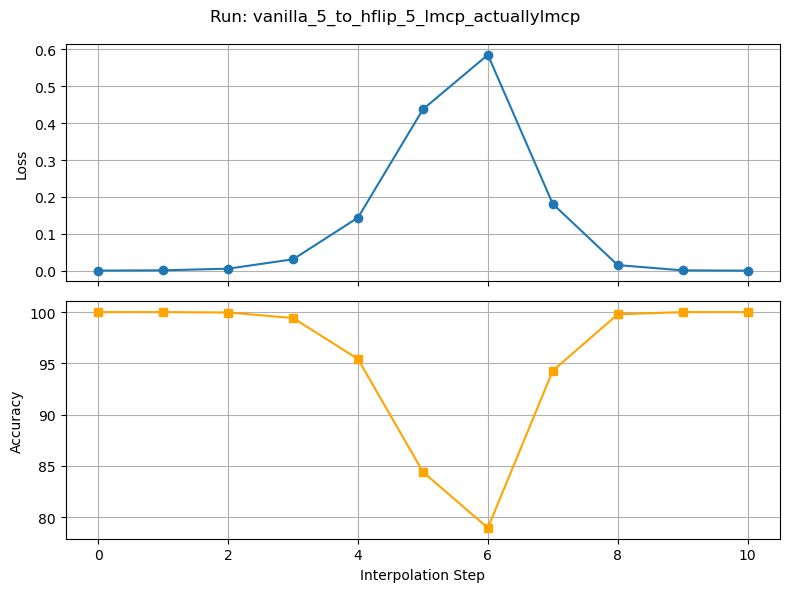

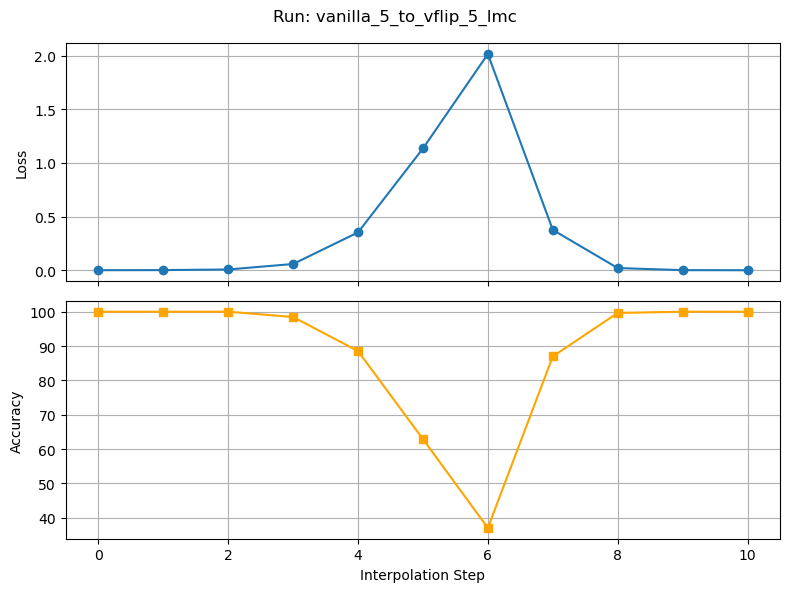

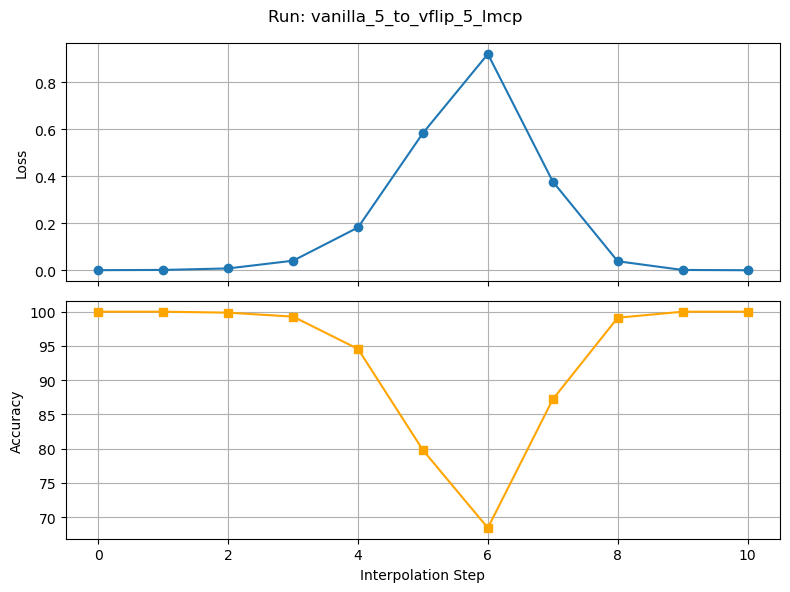

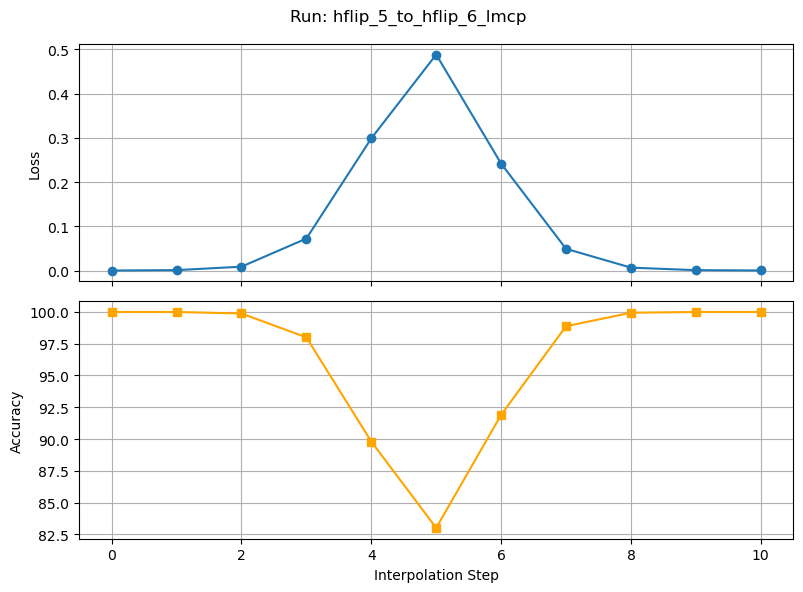

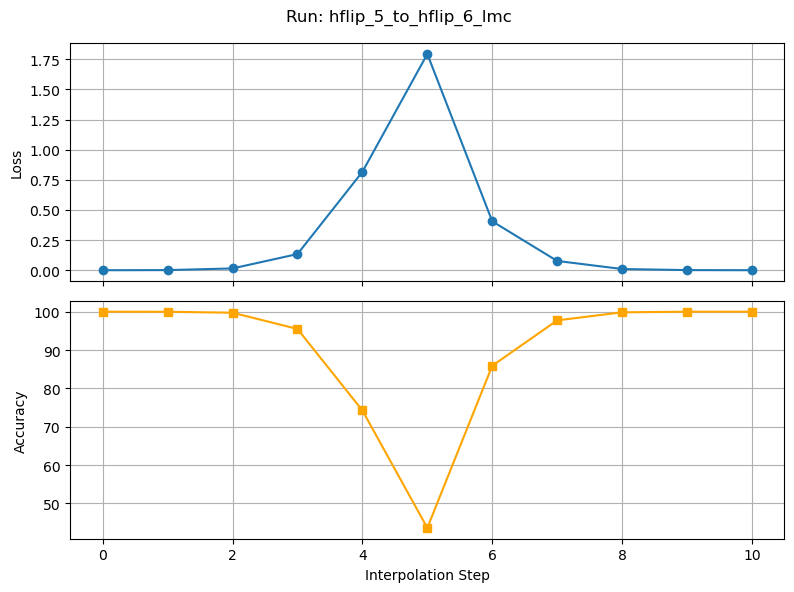

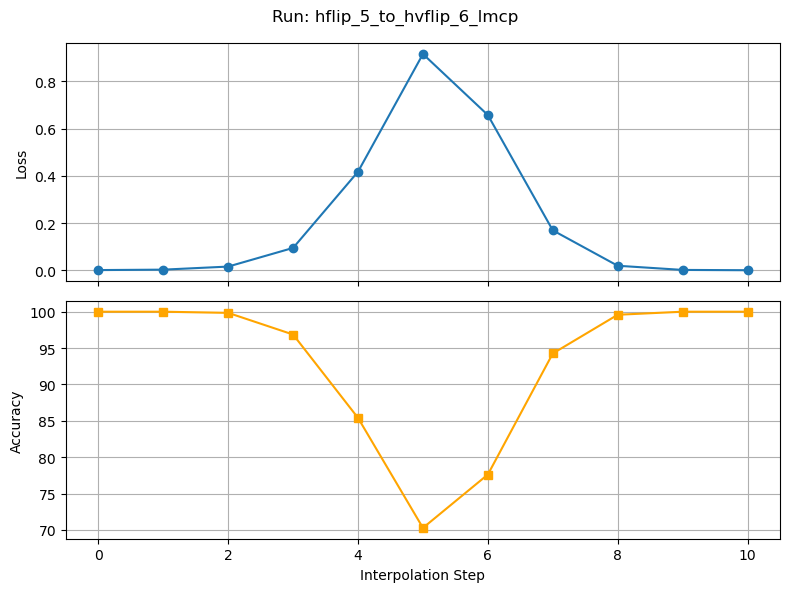

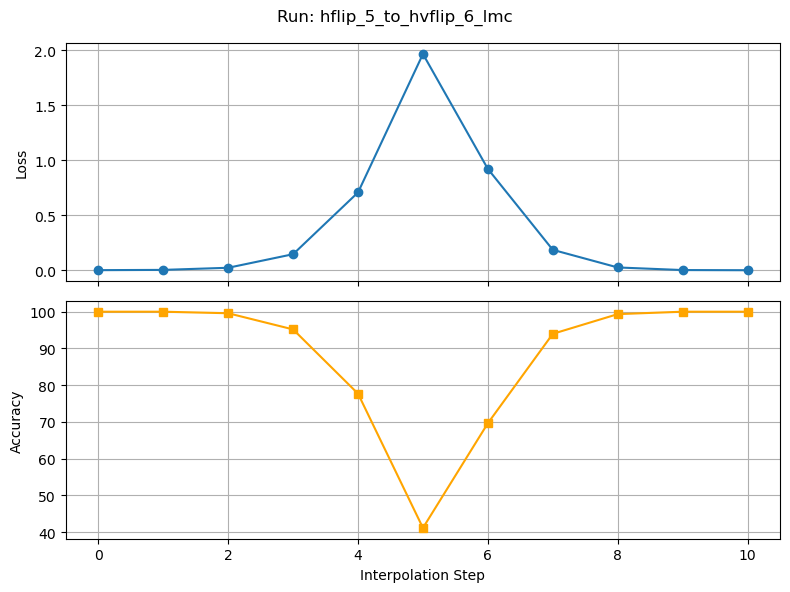

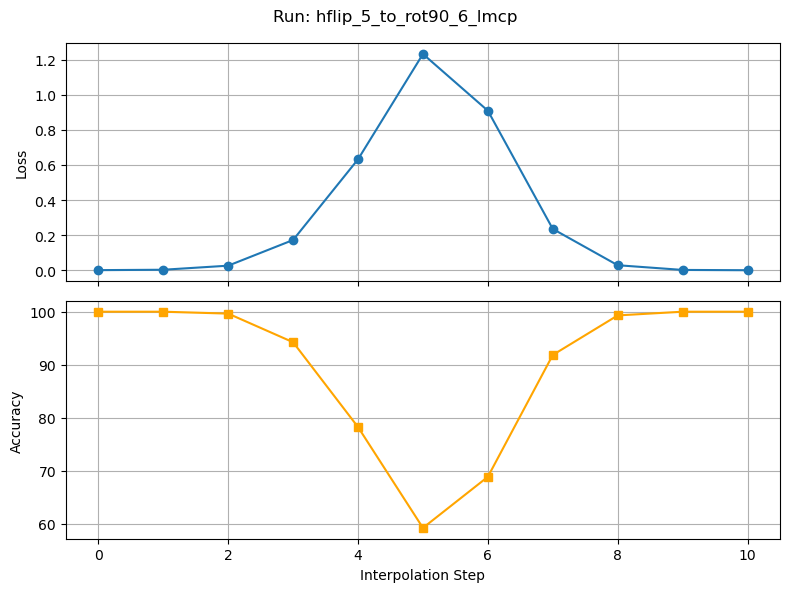

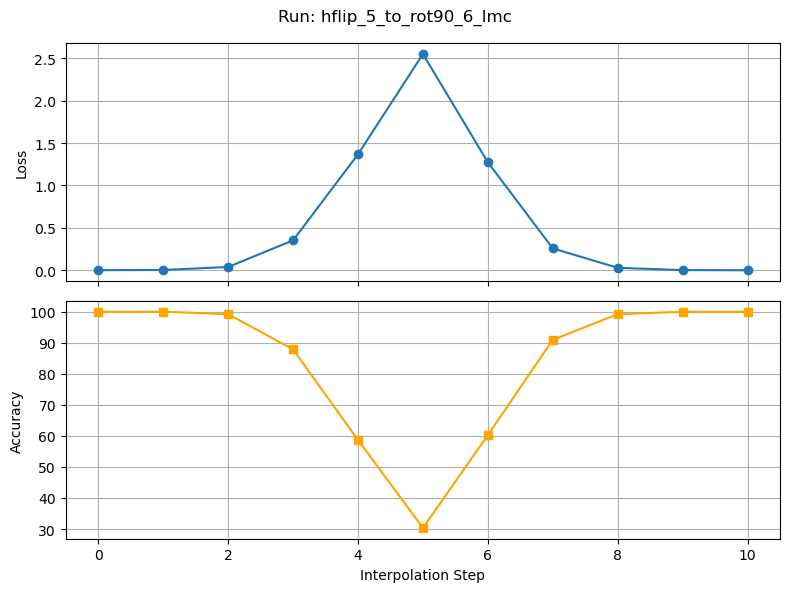

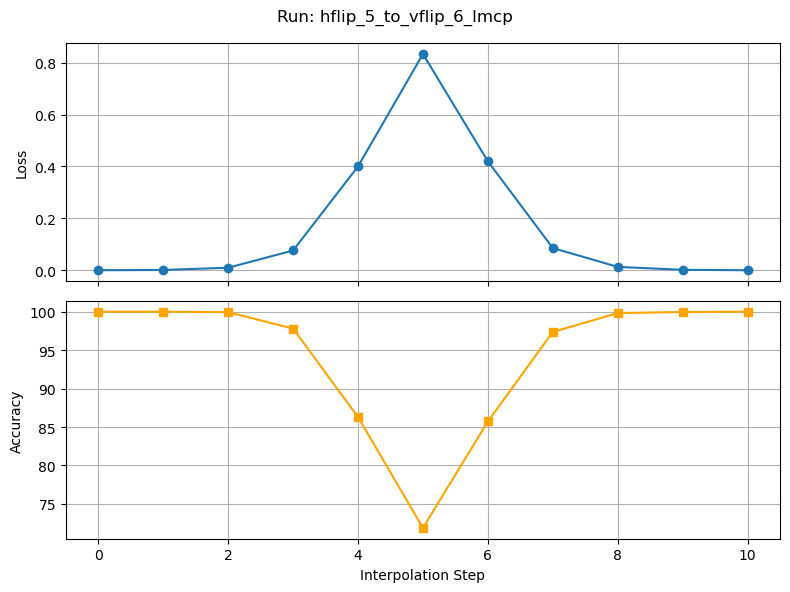

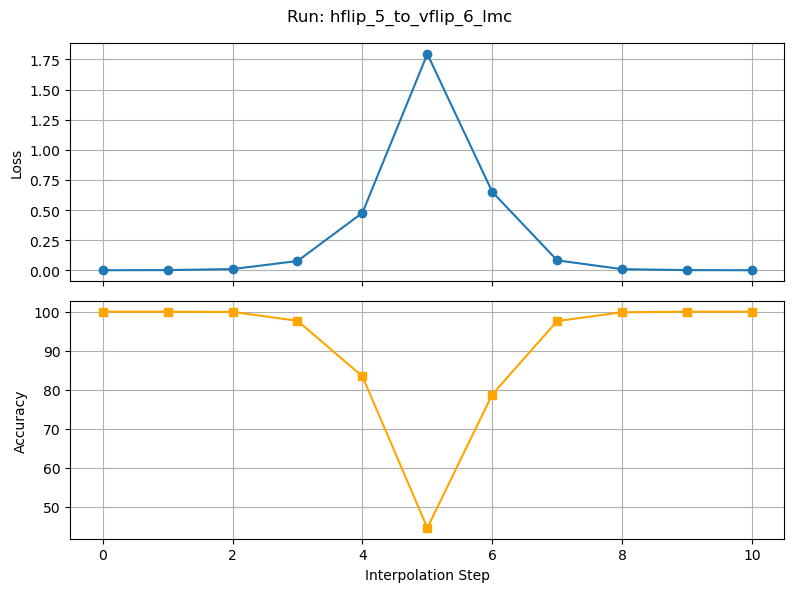

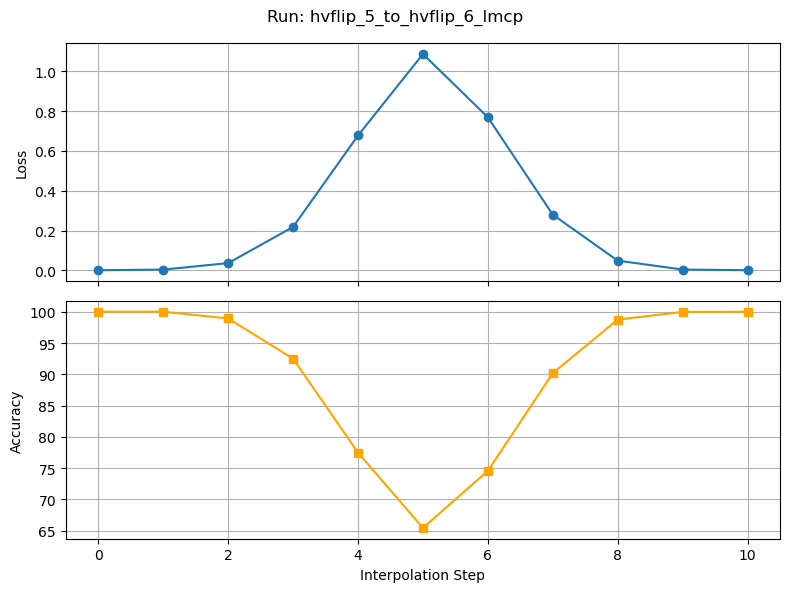

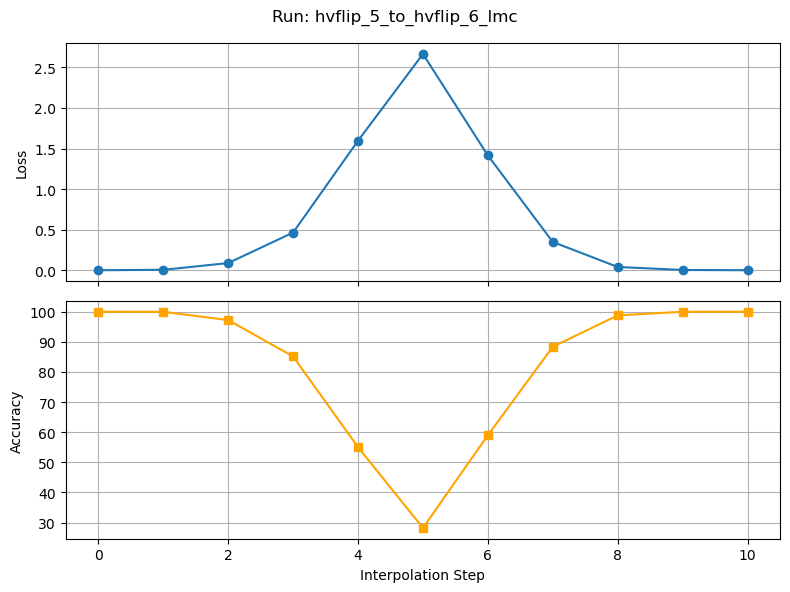

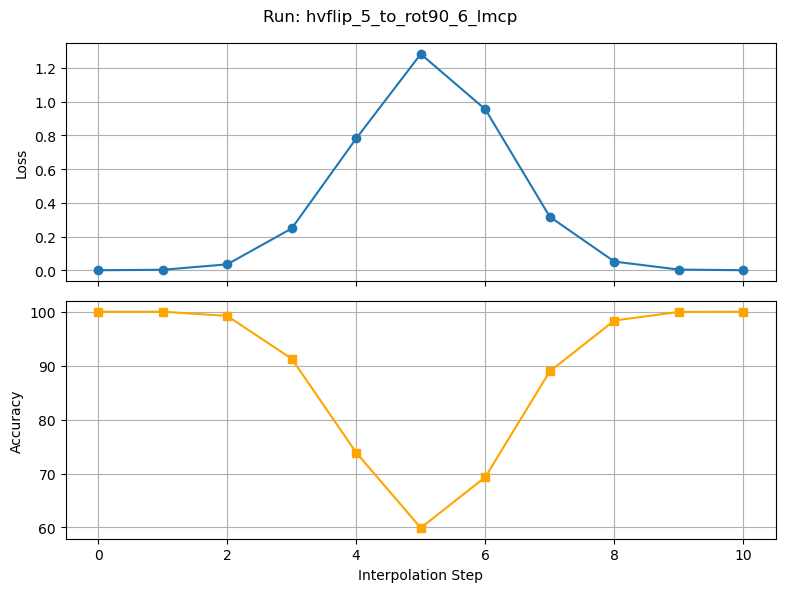

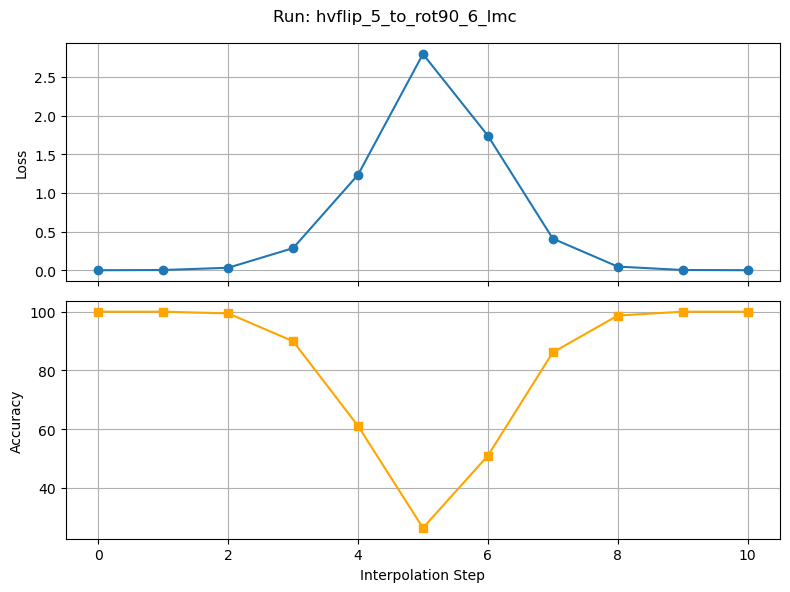

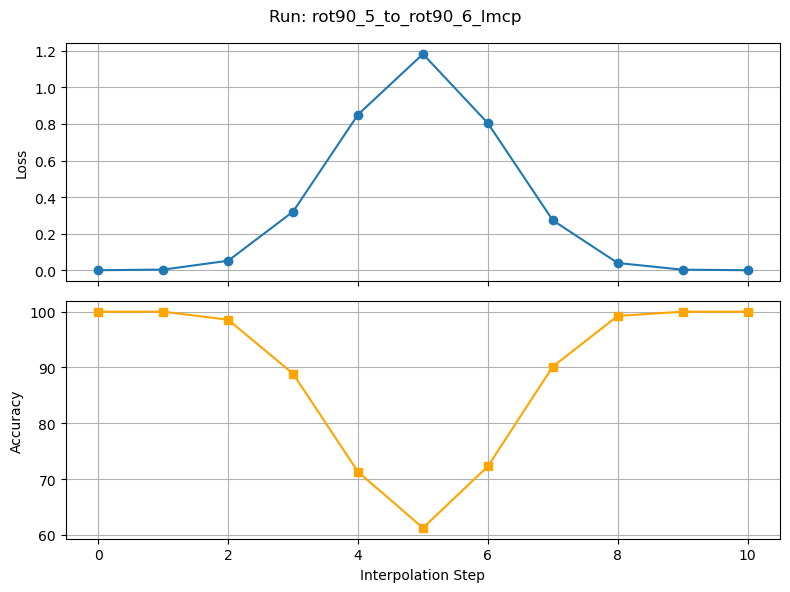

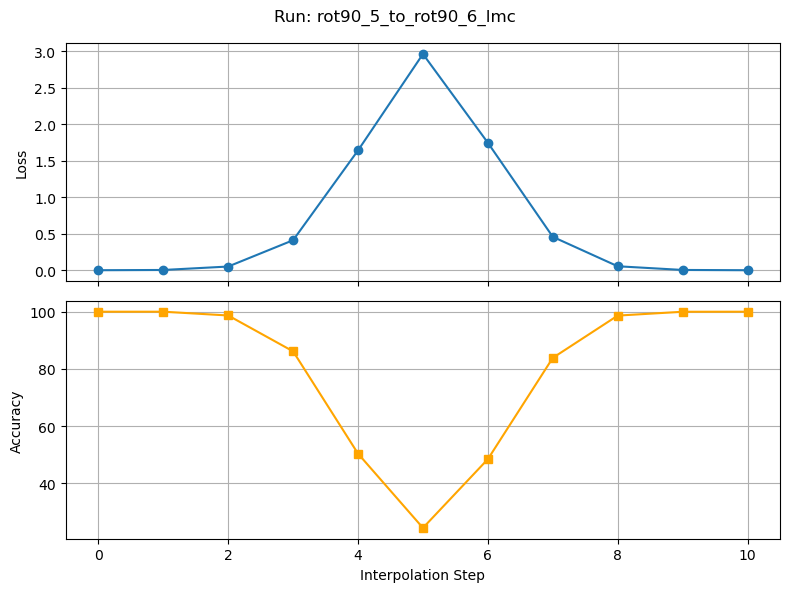

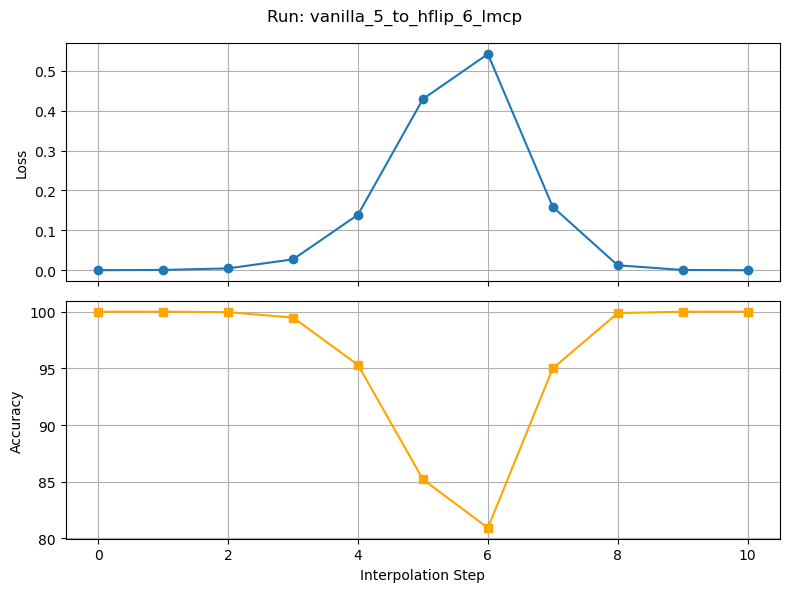

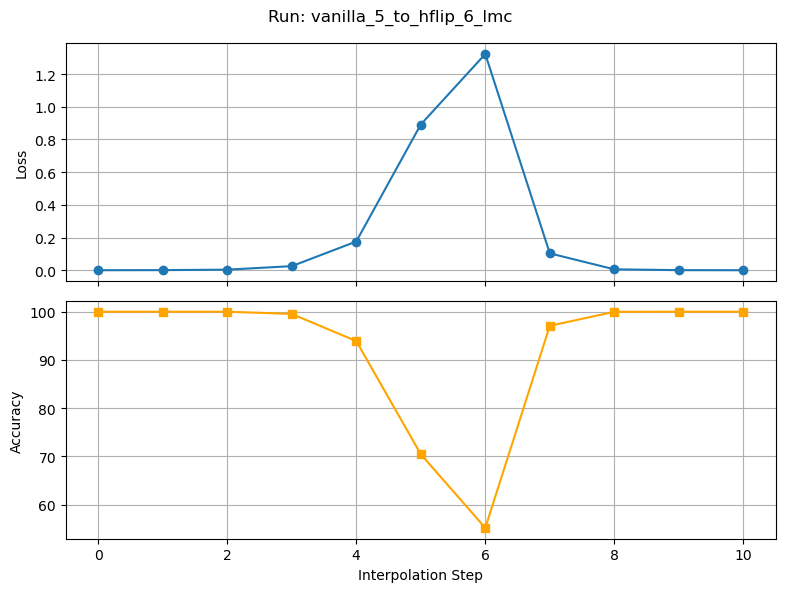

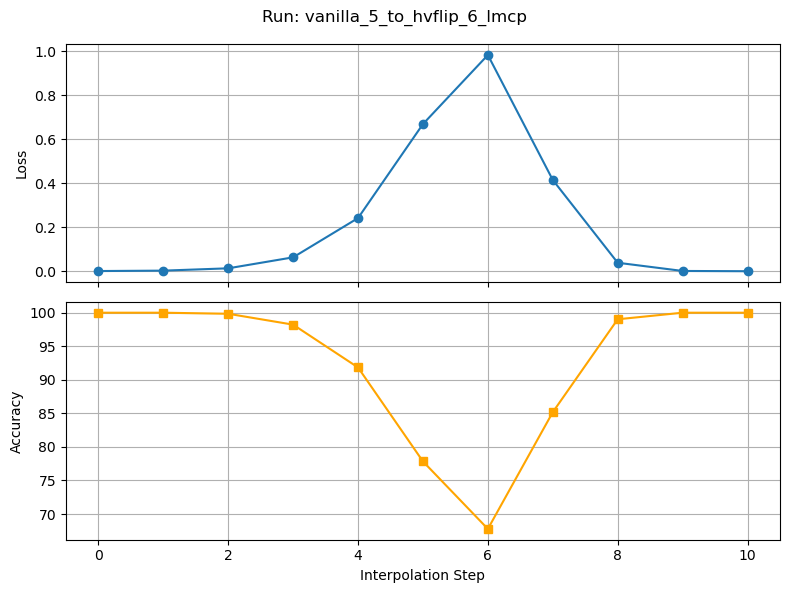

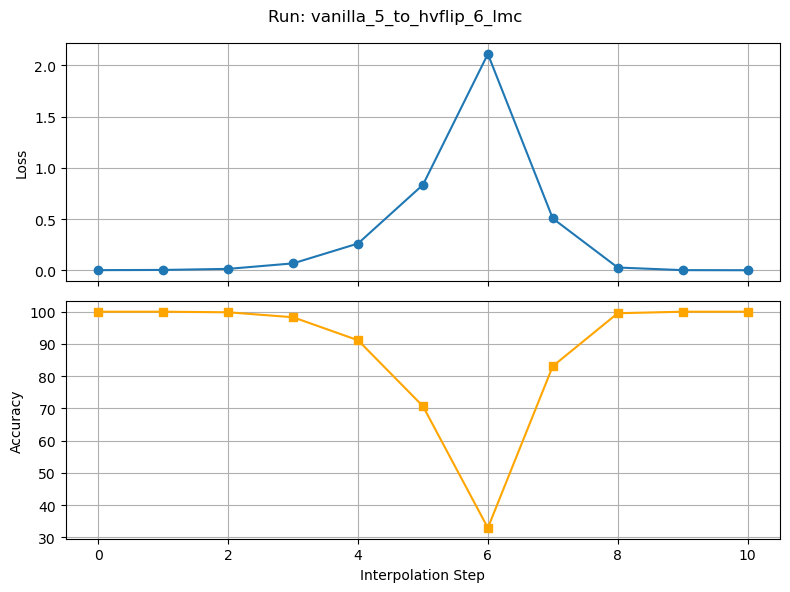

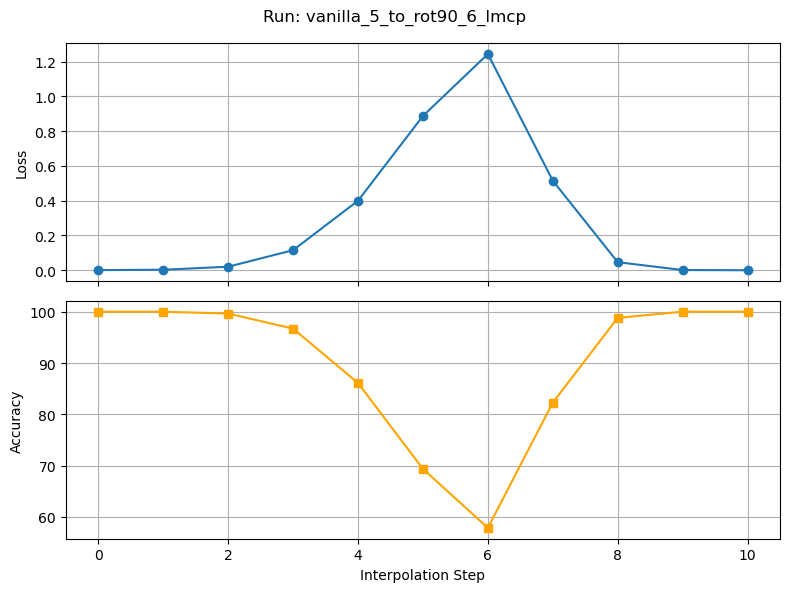

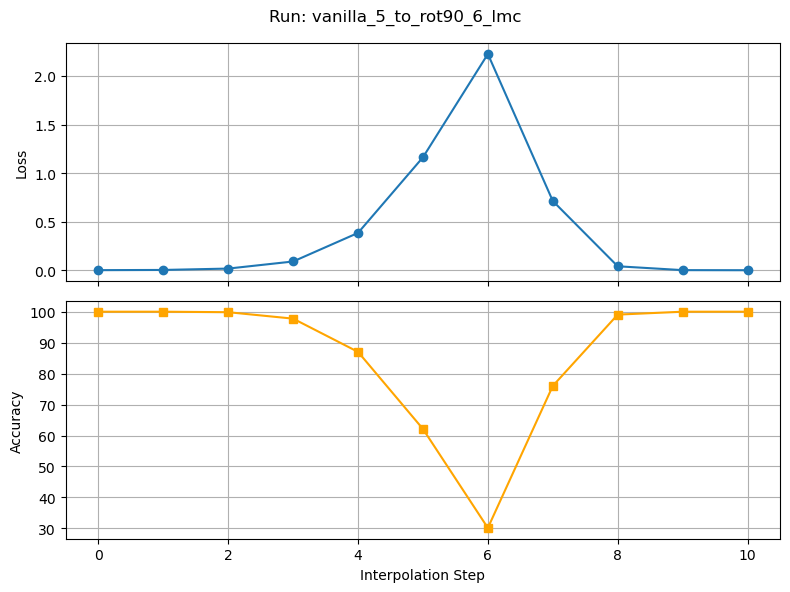

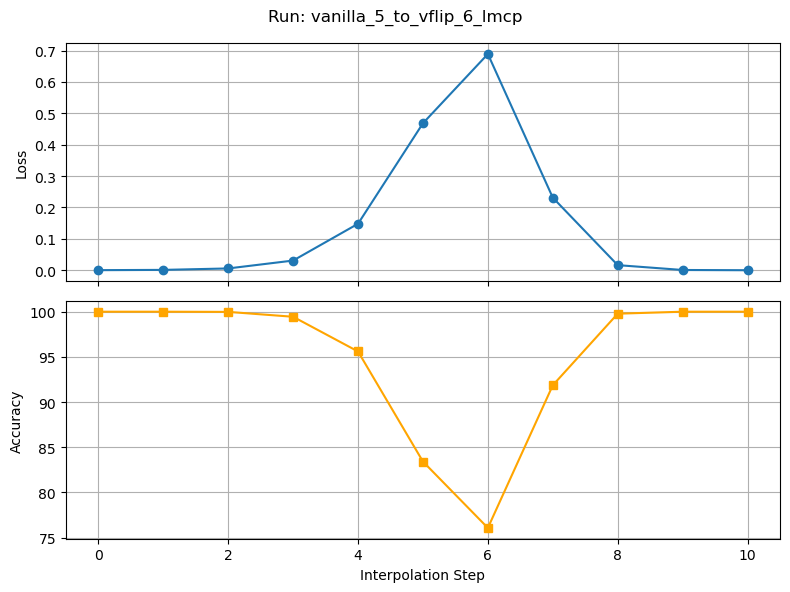

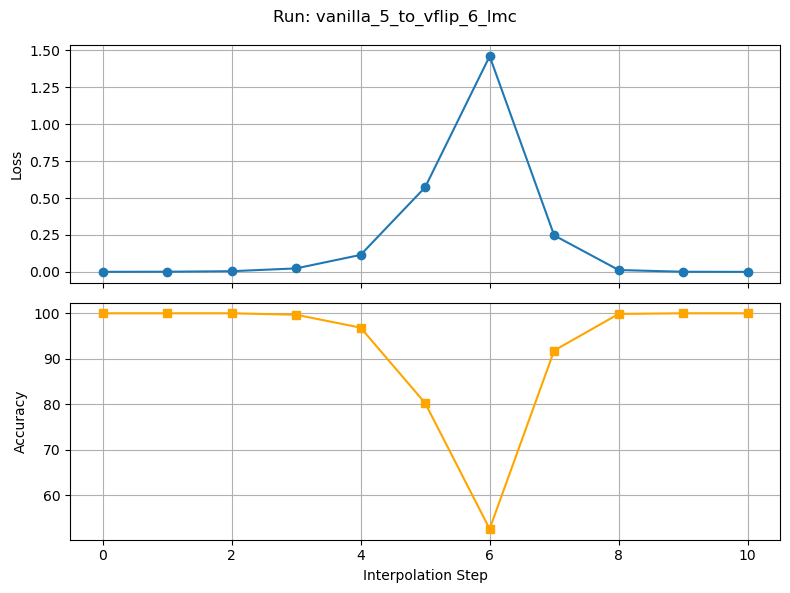

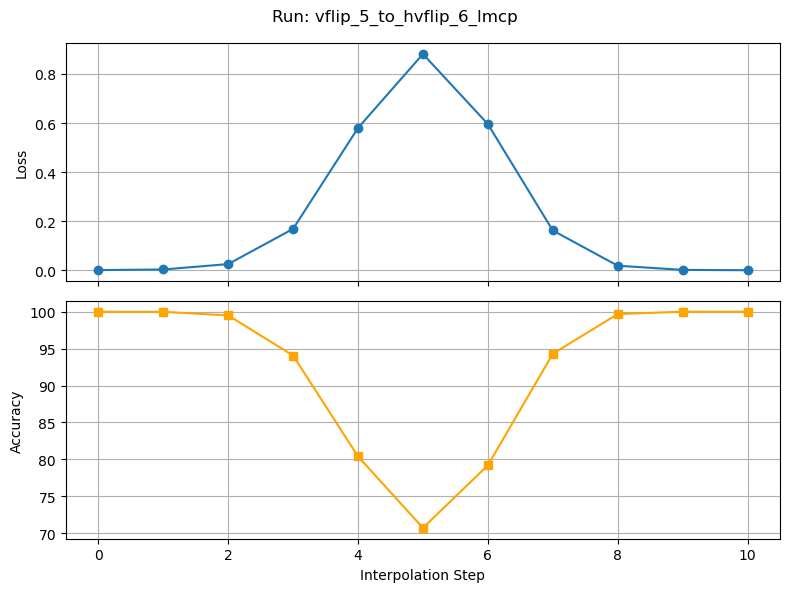

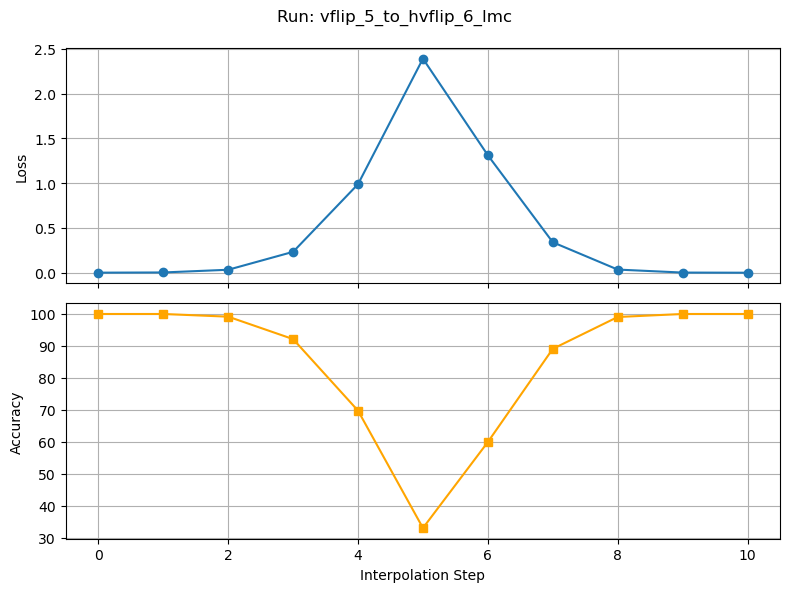

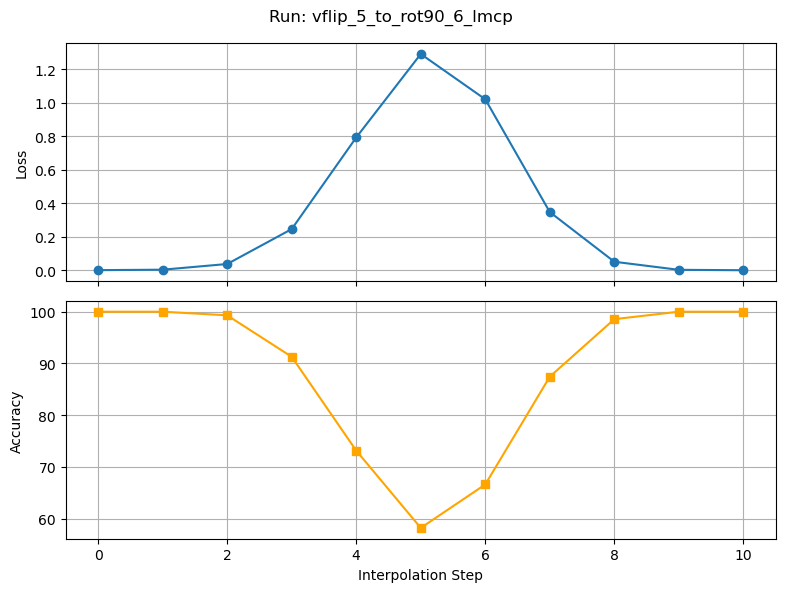

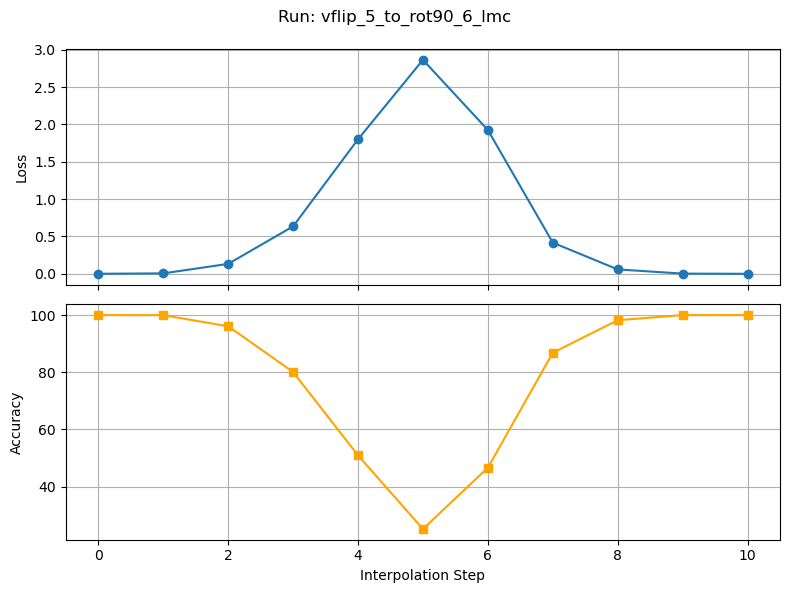

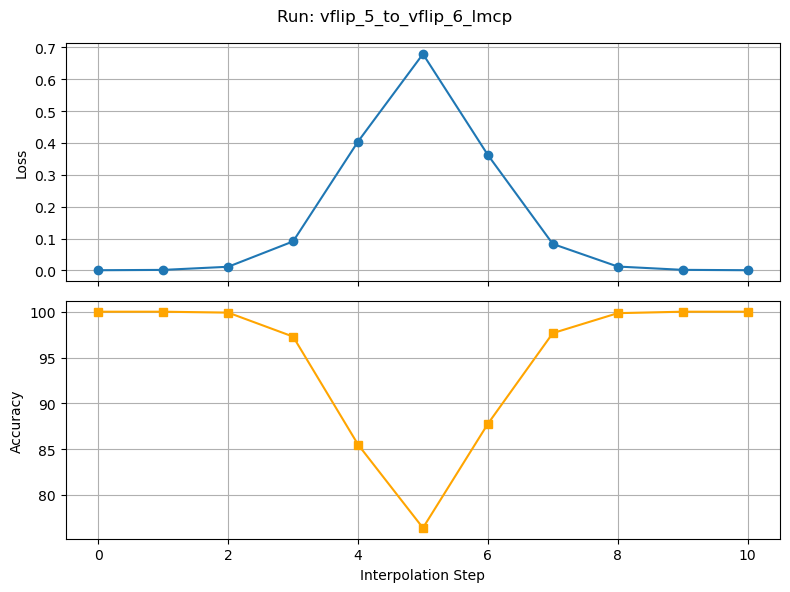

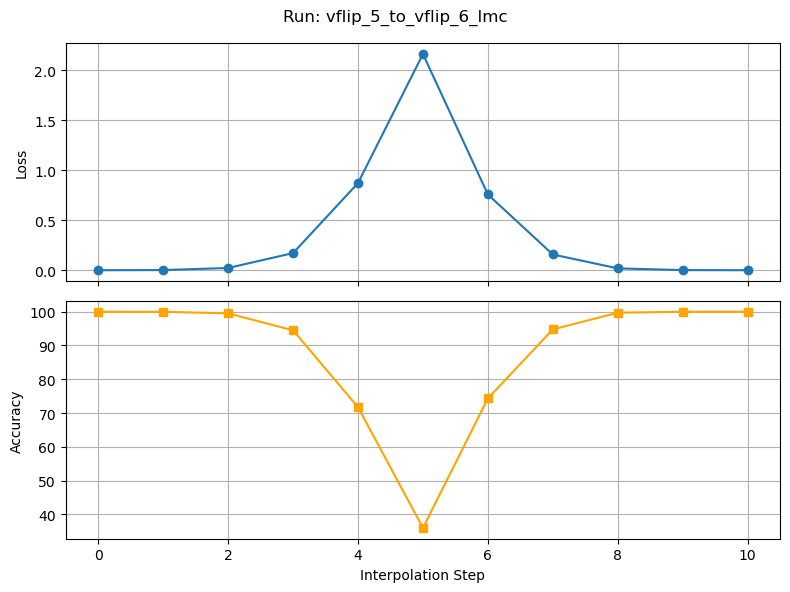

In [9]:
import os
import json
import matplotlib.pyplot as plt

# Directory containing all your JSON logs
log_dir = "./logs/connectivity"

# Collect data for all runs
all_results = []

for filename in os.listdir(log_dir):
    filepath = os.path.join(log_dir, filename)
    with open(filepath, "r") as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Warning: Could not decode {filename}, skipping.")
            continue
    
    losses = data.get("losses", [])
    accs = data.get("accs", [])
    
    # Use filename (minus extension) as run_id if none is provided
    run_id = filename.replace(".json", "")
    
    # Store each run's data for plotting
    all_results.append((run_id, losses, accs))
# Plot one figure (with two subplots) for each run
for run_id, losses, accs in all_results:
    steps_loss = range(len(losses))
    steps_acc = range(len(accs))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(f"Run: {run_id}")
    
    # Plot losses
    ax1.plot(steps_loss, losses, marker='o')
    ax1.set_ylabel("Loss")
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(steps_acc, accs, marker='s', color='orange')
    ax2.set_xlabel("Interpolation Step")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


# Linear Mode Connectivity

In [ ]:
model_1_path = "logs/vanilla_1/final_model.pt"
model_2_path = "logs/vflip_1/final_model.pt"

experiment_name = "exp_7"

num_steps = 10

data_config = {
  "dataset": "CIFAR10",
  "data_root": "./data/",
  "batch_size": 256,
  "data_augmentation": "vanilla",
  "augment_test":True
}

In [ ]:
train_loader, test_loader = get_data_loaders(data_config)

criterion = F.cross_entropy

device = "cuda" if torch.cuda.is_available() else "cpu"

Augmenting test data.
no data augmentation applied
Files already downloaded and verified
Files already downloaded and verified


In [ ]:

#create small dataset
idx = torch.randperm(len(train_loader.dataset))[:5000]
small_subset = Subset(train_loader.dataset, idx)

small_train_loader = DataLoader(small_subset,batch_size=data_config["batch_size"], shuffle=True)

#create small test dataset
idx = torch.randperm(len(test_loader.dataset))[:5000]
small_subset = Subset(test_loader.dataset, idx)

small_test_loader = DataLoader(small_subset,batch_size=data_config["batch_size"], shuffle=True)

In [ ]:
config = {
    "num_samples" : 10,
    "iters": 90
}

In [ ]:
#load the models
model_1 = ResNet18()
model_2 = ResNet18()

model_1.load_state_dict(torch.load(model_1_path))
model_2.load_state_dict(torch.load(model_2_path))

model_1 = model_1.to_normal()
model_2 = model_2.to_normal()

model_sym = res_permute(net_permuted=model_1, net_target=model_2, dataloader=permsmall_train_loader_loader,
                                    n_match_iters=config["iters"])

/tmp/ipykernel_21512/1763358611.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(model_1_path))
/tmp/ipykernel_21512/1763358611.py:6: F

In [ ]:
#Start testing for linear connectivity
alphas = np.linspace(0,1, num_steps)
losses = []
accs = []
for alpha in alphas:
    linear_model = linear_interpolated_model(model_1,model_2,alpha)
    loss, acc = evaluate_loss(linear_model, small_train_loader, small_test_loader, criterion, device)
    losses.append(loss)
    accs.append(acc)

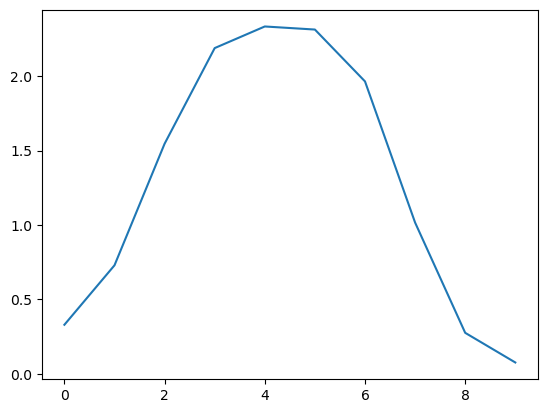

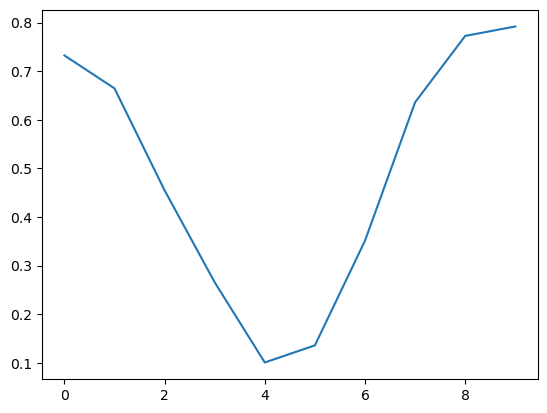

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(accs)
plt.show()

results = {
    "losses": losses,
    "accs": accs,
    "model_1": model_1_path,
    "model_2": model_2_path,
}
save_dir = "logs/interpolation/"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, experiment_name)
with open(save_path, "w") as f:
    json.dump(results, f, indent=4)

[[0.2949983894824982, 0.700042799115181, 1.5027632236480712, 2.1396888732910155, 2.3234723091125487, 2.2682294130325316, 1.8826153457164765, 0.9582026362419128, 0.2646514229476452, 0.0750483077019453], [0.5080499857664108, 0.8117012083530426, 1.5490236341953278, 2.152151620388031, 2.3247498631477357, 2.26949942111969, 1.8960003852844238, 1.0326856821775436, 0.4504474952816963, 0.4025859460234642]]


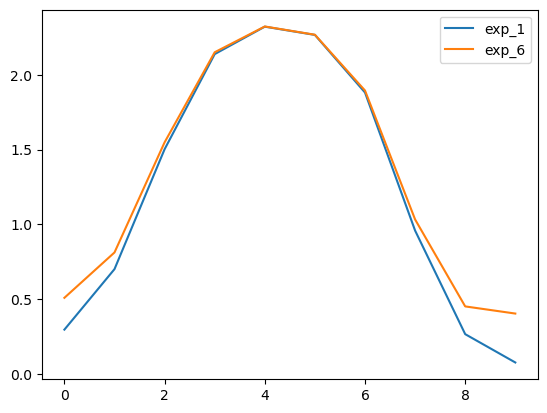

In [ ]:
losses = []
experiments = ["exp_1","exp_6"]
for exp in experiments:
    curr_path = os.path.join(save_dir, exp)
    with open(curr_path, "r") as f:
        config = json.load(f)
    losses.append(config["losses"])
print(losses)


for loss, label in zip(losses, experiments):
    plt.plot(loss, label=label)
plt.legend()